In [1]:
%%capture

import json
import os

os.chdir("..")

from IPython.display import Audio, Markdown, display

from dotenv import load_dotenv

load_dotenv()

from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest

# graph rendering
import nest_asyncio

nest_asyncio.apply()

# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

In [2]:
# create agent
agent = experiment_utils.create_openai_agent(
    agent_type="voice_memos", llm_tag="o3-mini", api_key=os.getenv("OPENAI_API_KEY")
)

In [3]:
# create attachment
attachment_id = experiment_utils.create_attachment(
    file_path="tests/integration/voice_memos_01_pt_BR.mp3", content_type="audio/mp3"
)

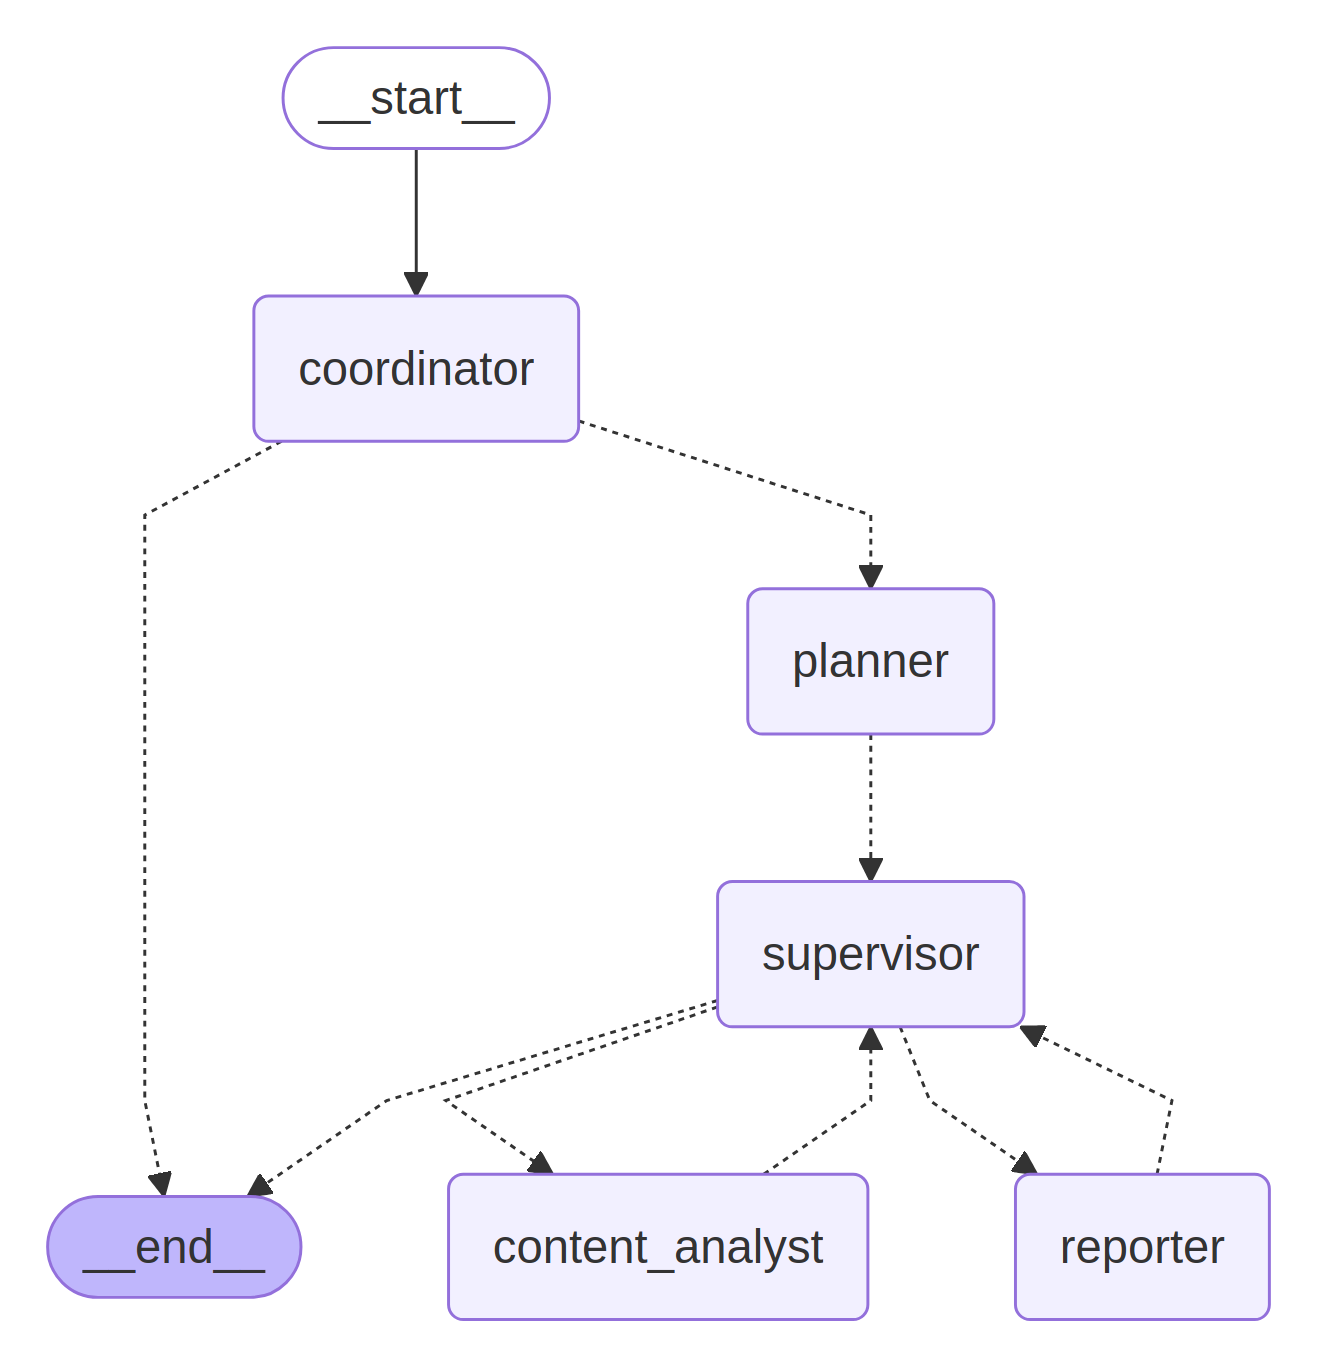

In [4]:
# get agent instance
voice_memos_agent = container.voice_memos_agent()

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

# Create Graph
workflow_builder = voice_memos_agent.get_workflow_builder(agent["id"])
workflow = workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(workflow)

In [5]:
%%capture

message = MessageRequest(
    message_role="human",
    message_content="Analyse the given audio.",
    agent_id=agent["id"],
    attachment_id=attachment_id,
)

inputs = voice_memos_agent.get_input_params(message)
config = voice_memos_agent.get_config(agent["id"])
result = workflow.invoke(inputs, config)
ai_message_content, workflow_state = voice_memos_agent.format_response(result)

In [6]:
file_path = "tests/integration/voice_memos_01_pt_BR.mp3"
display(Audio(file_path))

In [7]:
display(Markdown(f"**AI Message Content:**\n\n{ai_message_content}"))

**AI Message Content:**

**Main Topic**:  
- Desenvolvimento do projeto Agente X.

**Discussed points**:  
- Realização de uma reunião às 11 horas.  
- Participação da Aline, da equipe de marketing.  
- Atraso no projeto Agente X.  
- Necessidade de acelerar o desenvolvimento.  
- Preocupação da equipe de vendas com o prazo de entrega.  
- Agendamento de uma nova reunião para a próxima semana com atualização do projeto.

**Decisions taken**:  
- Acelerar o desenvolvimento do projeto.  
- Apresentar uma atualização do status do projeto na próxima reunião.

**Next steps**:  
- Preparar e apresentar uma atualização detalhada do projeto na reunião agendada para a próxima semana.

**Action points**:  
- Revisar o andamento do projeto e identificar pontos críticos.  
- Coordenar com as equipes de marketing e vendas para alinhar as expectativas e prazos.  
- Implementar ações para acelerar o desenvolvimento do projeto.

**Named entities**:  
- Aline – Equipe de marketing.

In [8]:
# display(Markdown(f"**Workflow state:**\n```json\n{ json.dumps(workflow_state, indent=2) }\n```"))
display(
    Markdown(
        f"**Structured report:**\n```json\n{json.dumps(workflow_state['execution_plan'], ensure_ascii=False, indent=2)}\n```"
    )
)

**Structured report:**
```json
{
  "thought": "O usuário forneceu uma transcrição de áudio que relata uma reunião ocorrida hoje às 11 horas com a Aline, da equipe de marketing, sobre o desenvolvimento do projeto Agente X. Na transcrição, é mencionado que o projeto está atrasado, que há necessidade de acelerar o desenvolvimento, e que a equipe de vendas está preocupada com o prazo de entrega, exigindo uma atualização na próxima reunião na semana que vem.",
  "title": "Análise da transcrição de áudio sobre o desenvolvimento do Projeto Agente X",
  "steps": [
    {
      "agent_name": "content_analyst",
      "title": "Análise da transcrição",
      "description": "Analisar a transcrição do áudio, extraindo informações relevantes como a data e hora da reunião, o interlocutor (Aline da equipe de marketing), os pontos críticos (atraso no projeto, necessidade de aceleração do desenvolvimento) e as preocupações envolvidas (equipe de vendas e prazo de entrega). Elaborar um relatório detalhado em Markdown com as descobertas."
    },
    {
      "agent_name": "reporter",
      "title": "Relatório Final",
      "description": "Formatar e apresentar o relatório final dos achados da análise em um documento JSON, contendo as informações extraídas e observações pertinentes sobre as ações necessárias para o desenvolvimento do projeto Agente X."
    }
  ]
}
```